# Facial recognition with support-vector machines (SVMs)

[Support-vector machines](https://en.wikipedia.org/wiki/Support-vector_machine), or SVMs, often do better than other models at fitting data — especially data is that is highly non-linear. The diagram on the left below shows a set of data points that a conventional linear model will not fit. In other words, there is no line you can draw to separate the blue points from the green points. However, you can add a third dimension to each data point based on its distance from the center. In 3D space (below right), you can then draw a plane that cleanly separates the two classes. This is the essence of how SVMs work, although when they add dimensions to your data, they typically add more than one. In some cases, they add an infinite number of dimensions! And they use *kernel tricks* to  do the math without actually computing values for all those new dimensions.

![](Images/svm.png)

That's a simple way to visualize how support-vector machines work. Let's learn about SVM by using the [Labeled Faces in the Wild](http://vis-www.cs.umass.edu/lfw/) (LFW) dataset provided with Scikit-learn to build a facial-recognition model.

## Load the dataset

The first step is to import facial images from the dataset. LFW contains more than 13,000 facial images collected from the Web. Of the more than 5,000 people represented in the dataset, 1,680 have two or more facial images, while only five have 100 or more. We'll set the minimum number of faces per person to 100, which means that five sets of faces corresponding to five famous people will be imported. Each facial image is labeled with the name of the person to whom the face belongs.

In [1]:
import numpy as np
import pandas as pd
from sklearn.datasets import fetch_lfw_people

faces = fetch_lfw_people(min_faces_per_person=100, slice_=None)
faces.images = faces.images[:, 35:97, 39:86]
faces.data = faces.images.reshape(faces.images.shape[0], faces.images.shape[1] * faces.images.shape[2])
print(faces.target_names)
print(faces.images.shape)

['Colin Powell' 'Donald Rumsfeld' 'George W Bush' 'Gerhard Schroeder'
 'Tony Blair']
(1140, 62, 47)


In total, 1,140 facial images were loaded. After cropping, each image measures 47 x 62 pixels for a total of 2,914 pixels per image. That means we're working with a dataset containing 2,914 feature columns. Use the following code to show the first 24 images in the dataset and the people to whom the faces belong.

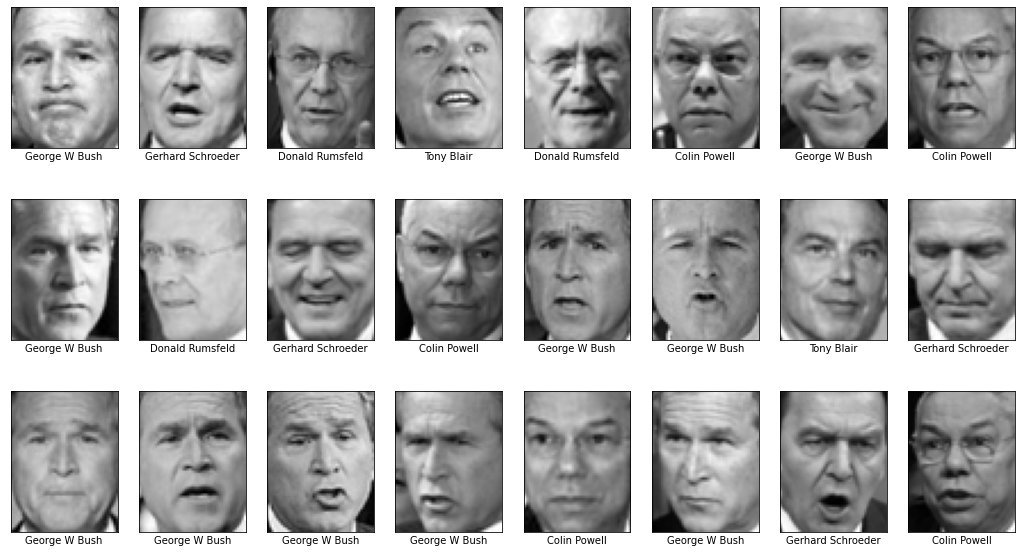

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt

fig, ax = plt.subplots(3, 8, figsize=(18, 10))
for i, axi in enumerate(ax.flat):
    axi.imshow(faces.images[i], cmap='gist_gray')
    axi.set(xticks=[], yticks=[], xlabel=faces.target_names[faces.target[i]])

Check the balance in the dataset by generating a histogram showing how many facial images were imported for each person.

<AxesSubplot:>

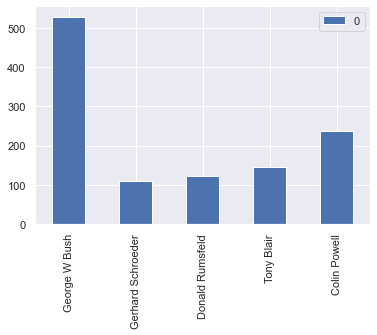

In [3]:
import seaborn as sns
sns.set()

from collections import Counter
counts = Counter(faces.target)
names = {}

for key in counts.keys():
    names[faces.target_names[key]] = counts[key]

df = pd.DataFrame.from_dict(names, orient='index')
df.plot(kind='bar')

There are far more images of George W. Bush than of anyone else in the dataset. Classification models are best trained with balanced datasets. Use the following code to reduce the dataset to 100 images of each person.

In [4]:
mask = np.zeros(faces.target.shape, dtype=bool)

for target in np.unique(faces.target):
    mask[np.where(faces.target == target)[0][:100]] = 1
    
x = faces.data[mask]
y = faces.target[mask]
x.shape

(500, 2914)

`x` contains 500 facial images, and `y` contains the labels that go with them: 0 for Colin Powell, 1 for Donald Rumsfeld, and so on. Now let's see if an SVM can make sense of the data.

## Use an SVM to classify facial images

The next task is to train an SVM model to do image classification using the faces in the dataset. We'll train three different models: one that uses a linear kernel, one that uses a polynomial kernel, and one that uses an RBF kernel. In each case, we'll use [`GridSearchCV`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html) to optimize hyperparameters. Start with a linear model.

In [5]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

svc = SVC(kernel='linear')

grid = {
    'C': [0.1, 1, 10, 100]
}

grid_search = GridSearchCV(estimator=svc, param_grid=grid, cv=5, verbose=2)
grid_search.fit(x, y) # Train the model with different parameters
grid_search.best_score_

Fitting 5 folds for each of 4 candidates, totalling 20 fits
[CV] END ..............................................C=0.1; total time=   0.0s
[CV] END ..............................................C=0.1; total time=   0.0s
[CV] END ..............................................C=0.1; total time=   0.0s
[CV] END ..............................................C=0.1; total time=   0.0s
[CV] END ..............................................C=0.1; total time=   0.0s
[CV] END ................................................C=1; total time=   0.1s
[CV] END ................................................C=1; total time=   0.0s
[CV] END ................................................C=1; total time=   0.0s
[CV] END ................................................C=1; total time=   0.0s
[CV] END ................................................C=1; total time=   0.0s
[CV] END ...............................................C=10; total time=   0.0s
[CV] END ........................................

0.842

This model achieved a cross-validated accuracy of 84.2%. It's possible that accuracy can be improved by standardizing the image data. Run the same grid search again, but this time use [`StandardScaler`](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) to apply unit variance to all the pixel values.

In [6]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
svc = SVC(kernel='linear')
pipe = make_pipeline(scaler, svc)

grid = {
    'svc__C': [0.1, 1, 10, 100]
}

grid_search = GridSearchCV(estimator=pipe, param_grid=grid, cv=5, verbose=2)
grid_search.fit(x, y)
grid_search.best_score_

Fitting 5 folds for each of 4 candidates, totalling 20 fits
[CV] END .........................................svc__C=0.1; total time=   0.0s
[CV] END .........................................svc__C=0.1; total time=   0.1s
[CV] END .........................................svc__C=0.1; total time=   0.0s
[CV] END .........................................svc__C=0.1; total time=   0.0s
[CV] END .........................................svc__C=0.1; total time=   0.0s
[CV] END ...........................................svc__C=1; total time=   0.1s
[CV] END ...........................................svc__C=1; total time=   0.1s
[CV] END ...........................................svc__C=1; total time=   0.1s
[CV] END ...........................................svc__C=1; total time=   0.0s
[CV] END ...........................................svc__C=1; total time=   0.1s
[CV] END ..........................................svc__C=10; total time=   0.1s
[CV] END ........................................

0.8560000000000001

Standardizing the data produced an incremental improvement in accuracy. What value of `C` produced that accuracy?

In [7]:
grid_search.best_params_

{'svc__C': 0.1}

Is it possible that a polynomial kernel could outperform a linear kernel? There's an easy way to find out. Note the introduction of the `gamma` and `degree` parameters to the parameter grid. These parameters, along with `C`, can greatly influence a polynomial kernel's ability to fit to the training data.

In [8]:
scaler = StandardScaler()
svc = SVC(kernel='poly')
pipe = make_pipeline(scaler, svc)

grid = {
    'svc__C': [0.1, 1, 10, 100],
    'svc__gamma': [0.01, 0.25, 0.5, 0.75, 1],
    'svc__degree': [1, 2, 3, 4, 5]
}

grid_search = GridSearchCV(estimator=pipe, param_grid=grid, cv=5, verbose=2)
grid_search.fit(x, y)
grid_search.best_score_

Fitting 5 folds for each of 100 candidates, totalling 500 fits
[CV] END .........svc__C=0.1, svc__degree=1, svc__gamma=0.01; total time=   0.0s
[CV] END .........svc__C=0.1, svc__degree=1, svc__gamma=0.01; total time=   0.0s
[CV] END .........svc__C=0.1, svc__degree=1, svc__gamma=0.01; total time=   0.0s
[CV] END .........svc__C=0.1, svc__degree=1, svc__gamma=0.01; total time=   0.0s
[CV] END .........svc__C=0.1, svc__degree=1, svc__gamma=0.01; total time=   0.0s
[CV] END .........svc__C=0.1, svc__degree=1, svc__gamma=0.25; total time=   0.0s
[CV] END .........svc__C=0.1, svc__degree=1, svc__gamma=0.25; total time=   0.0s
[CV] END .........svc__C=0.1, svc__degree=1, svc__gamma=0.25; total time=   0.0s
[CV] END .........svc__C=0.1, svc__degree=1, svc__gamma=0.25; total time=   0.0s
[CV] END .........svc__C=0.1, svc__degree=1, svc__gamma=0.25; total time=   0.0s
[CV] END ..........svc__C=0.1, svc__degree=1, svc__gamma=0.5; total time=   0.1s
[CV] END ..........svc__C=0.1, svc__degree=1, 

[CV] END .........svc__C=0.1, svc__degree=5, svc__gamma=0.01; total time=   0.1s
[CV] END .........svc__C=0.1, svc__degree=5, svc__gamma=0.01; total time=   0.1s
[CV] END .........svc__C=0.1, svc__degree=5, svc__gamma=0.01; total time=   0.1s
[CV] END .........svc__C=0.1, svc__degree=5, svc__gamma=0.01; total time=   0.1s
[CV] END .........svc__C=0.1, svc__degree=5, svc__gamma=0.25; total time=   0.1s
[CV] END .........svc__C=0.1, svc__degree=5, svc__gamma=0.25; total time=   0.1s
[CV] END .........svc__C=0.1, svc__degree=5, svc__gamma=0.25; total time=   0.1s
[CV] END .........svc__C=0.1, svc__degree=5, svc__gamma=0.25; total time=   0.1s
[CV] END .........svc__C=0.1, svc__degree=5, svc__gamma=0.25; total time=   0.1s
[CV] END ..........svc__C=0.1, svc__degree=5, svc__gamma=0.5; total time=   0.1s
[CV] END ..........svc__C=0.1, svc__degree=5, svc__gamma=0.5; total time=   0.1s
[CV] END ..........svc__C=0.1, svc__degree=5, svc__gamma=0.5; total time=   0.1s
[CV] END ..........svc__C=0.

[CV] END ...........svc__C=1, svc__degree=4, svc__gamma=0.01; total time=   0.1s
[CV] END ...........svc__C=1, svc__degree=4, svc__gamma=0.01; total time=   0.1s
[CV] END ...........svc__C=1, svc__degree=4, svc__gamma=0.25; total time=   0.1s
[CV] END ...........svc__C=1, svc__degree=4, svc__gamma=0.25; total time=   0.1s
[CV] END ...........svc__C=1, svc__degree=4, svc__gamma=0.25; total time=   0.1s
[CV] END ...........svc__C=1, svc__degree=4, svc__gamma=0.25; total time=   0.1s
[CV] END ...........svc__C=1, svc__degree=4, svc__gamma=0.25; total time=   0.1s
[CV] END ............svc__C=1, svc__degree=4, svc__gamma=0.5; total time=   0.1s
[CV] END ............svc__C=1, svc__degree=4, svc__gamma=0.5; total time=   0.1s
[CV] END ............svc__C=1, svc__degree=4, svc__gamma=0.5; total time=   0.1s
[CV] END ............svc__C=1, svc__degree=4, svc__gamma=0.5; total time=   0.1s
[CV] END ............svc__C=1, svc__degree=4, svc__gamma=0.5; total time=   0.1s
[CV] END ...........svc__C=1

[CV] END ..........svc__C=10, svc__degree=3, svc__gamma=0.25; total time=   0.1s
[CV] END ..........svc__C=10, svc__degree=3, svc__gamma=0.25; total time=   0.1s
[CV] END ..........svc__C=10, svc__degree=3, svc__gamma=0.25; total time=   0.1s
[CV] END ..........svc__C=10, svc__degree=3, svc__gamma=0.25; total time=   0.1s
[CV] END ..........svc__C=10, svc__degree=3, svc__gamma=0.25; total time=   0.1s
[CV] END ...........svc__C=10, svc__degree=3, svc__gamma=0.5; total time=   0.1s
[CV] END ...........svc__C=10, svc__degree=3, svc__gamma=0.5; total time=   0.1s
[CV] END ...........svc__C=10, svc__degree=3, svc__gamma=0.5; total time=   0.1s
[CV] END ...........svc__C=10, svc__degree=3, svc__gamma=0.5; total time=   0.1s
[CV] END ...........svc__C=10, svc__degree=3, svc__gamma=0.5; total time=   0.1s
[CV] END ..........svc__C=10, svc__degree=3, svc__gamma=0.75; total time=   0.1s
[CV] END ..........svc__C=10, svc__degree=3, svc__gamma=0.75; total time=   0.1s
[CV] END ..........svc__C=10

[CV] END .........svc__C=100, svc__degree=2, svc__gamma=0.25; total time=   0.1s
[CV] END .........svc__C=100, svc__degree=2, svc__gamma=0.25; total time=   0.1s
[CV] END .........svc__C=100, svc__degree=2, svc__gamma=0.25; total time=   0.1s
[CV] END ..........svc__C=100, svc__degree=2, svc__gamma=0.5; total time=   0.1s
[CV] END ..........svc__C=100, svc__degree=2, svc__gamma=0.5; total time=   0.1s
[CV] END ..........svc__C=100, svc__degree=2, svc__gamma=0.5; total time=   0.1s
[CV] END ..........svc__C=100, svc__degree=2, svc__gamma=0.5; total time=   0.1s
[CV] END ..........svc__C=100, svc__degree=2, svc__gamma=0.5; total time=   0.1s
[CV] END .........svc__C=100, svc__degree=2, svc__gamma=0.75; total time=   0.1s
[CV] END .........svc__C=100, svc__degree=2, svc__gamma=0.75; total time=   0.1s
[CV] END .........svc__C=100, svc__degree=2, svc__gamma=0.75; total time=   0.1s
[CV] END .........svc__C=100, svc__degree=2, svc__gamma=0.75; total time=   0.1s
[CV] END .........svc__C=100

0.8560000000000001

The polynomial kernel achieved the same accuracy as the linear kernel. What parameter values led to this result?

In [9]:
grid_search.best_params_

{'svc__C': 0.1, 'svc__degree': 1, 'svc__gamma': 0.25}

`best_params_` reveals that the optimum value of `degree` was 1, which means the polynomial kernel acted like a linear kernel. It's not surprising, then, that it achieved the same accuracy. Could an RBF kernel do better?

In [10]:
scaler = StandardScaler()
svc = SVC(kernel='rbf')
pipe = make_pipeline(scaler, svc)

grid = {
    'svc__C': [0.1, 1, 10, 100],
    'svc__gamma': [0.01, 0.25, 0.5, 0.75, 1.0]
}

grid_search = GridSearchCV(estimator=pipe, param_grid=grid, cv=5, verbose=2)
grid_search.fit(x, y)
grid_search.best_score_

Fitting 5 folds for each of 20 candidates, totalling 100 fits
[CV] END ........................svc__C=0.1, svc__gamma=0.01; total time=   0.2s
[CV] END ........................svc__C=0.1, svc__gamma=0.01; total time=   0.2s
[CV] END ........................svc__C=0.1, svc__gamma=0.01; total time=   0.2s
[CV] END ........................svc__C=0.1, svc__gamma=0.01; total time=   0.2s
[CV] END ........................svc__C=0.1, svc__gamma=0.01; total time=   0.2s
[CV] END ........................svc__C=0.1, svc__gamma=0.25; total time=   0.2s
[CV] END ........................svc__C=0.1, svc__gamma=0.25; total time=   0.2s
[CV] END ........................svc__C=0.1, svc__gamma=0.25; total time=   0.2s
[CV] END ........................svc__C=0.1, svc__gamma=0.25; total time=   0.2s
[CV] END ........................svc__C=0.1, svc__gamma=0.25; total time=   0.2s
[CV] END .........................svc__C=0.1, svc__gamma=0.5; total time=   0.2s
[CV] END .........................svc__C=0.1, s

0.472

The RBF kernel didn't perform as well as the linear and polynomial kernels. There's a lesson here. The RBF kernel *often* fits to non-linear data better than other kernels, but it doesn't *always* fit better. That's why the best strategy with an SVM is to try different kernels with different parameter values. The best combination will vary from dataset to dataset. For the LFW dataset, it seems that a linear kernel is best. That's convenient, because the linear kernel is the fastest of all the kernels that Scikit provides.

## Visualize the model's performance

Confusion matrices are a great way to visual a model's accuracy. Let's split the dataset, train an optimized linear model with 80% of the images, test it with the remaining 20%, and show the results in a confusion matrix. The first step is to split the dataset. Note the `stratify=y` parameter, which ensures that the training dataset and the test dataset have the same proportion of samples of each class as the original dataset. In this example, the training dataset will contain 20 samples of each of the five people.

In [11]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(x, y, train_size=0.8, stratify=y, random_state=0)

Now train a linear SVM with the optimum `C` value revealed by the grid search.

In [12]:
scaler = StandardScaler()
svc = SVC(kernel='linear', C=0.1)
pipe = make_pipeline(scaler, svc)
pipe.fit(x_train, y_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('svc', SVC(C=0.1, kernel='linear'))])

Use a confusion matrix to see how the model performs against the test data.

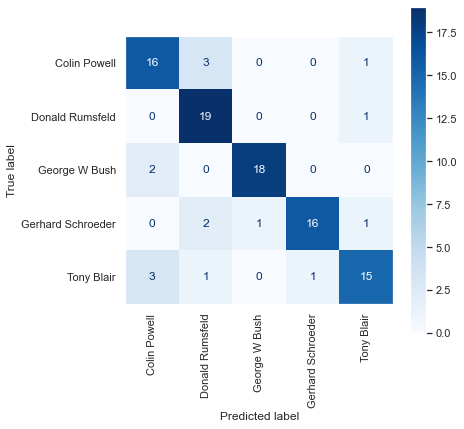

In [14]:
from sklearn.metrics import ConfusionMatrixDisplay as cmd

fig, ax = plt.subplots(figsize=(6, 6))
ax.grid(False)
cmd.from_estimator(pipe, x_test, y_test, display_labels=faces.target_names, cmap='Blues', xticks_rotation='vertical', ax=ax)

The model correctly identified Colin Powell 19 times out of 20, Donald Rumsfeld 20 times out of 20, and so on. That's not bad. And it's a great example of support-vector machines at work. It would be challenging, perhaps impossible, to do this well using more conventional learning algorithms such as logistic regression.